In [1]:
using QuantumOptics
using OrdinaryDiffEq
using ModelingToolkit
using LinearAlgebra
using Symbolics
using SymbolicUtils
using DifferentialEquations
using Plots

In [2]:
include("../../src/indexing.jl")
include("../../src/doubleSums.jl")
include("../../src/averageSums.jl")
include("../../src/indexedMeanfield.jl")

substReds (generic function with 2 methods)

In [3]:
# Parameters
N = 4 #number of atoms
order = 3
κ, g, Γ23, Γ13, Γ12, Ω, Δc, Δ3 = cnumbers("κ g Γ_{23} Γ_{13} Γ_{12} Ω Δ_c Δ_3")

# Hilbertspace
hf = FockSpace(:cavity)
ha = ⊗([NLevelSpace(Symbol(:atom,i),3) for i=1:N]...)
h = hf ⊗ ha

# Operators
a = Destroy(h,:a)
σ(i,j,k) = Transition(h,Symbol("σ_{$k}"),i,j,k+1)

σ (generic function with 1 method)

In [4]:
# Hamiltonian
H = -Δc*a'a + sum(g*(a'*σ(1,2,i) + a*σ(2,1,i)) for i=1:N) + sum(Ω*(σ(3,1,i) + σ(1,3,i)) for i=1:N) - sum(Δ3*σ(3,3,i) for i=1:N)

# Jumps
J = [a;[σ(1,2,i) for i=1:N];[σ(1,3,i) for i=1:N];[σ(2,3,i) for i=1:N]]

# Rates
rates = [κ;[Γ12 for i=1:N];[Γ13 for i=1:N];[Γ23 for i=1:N]]

13-element Vector{Sym{Parameter, Base.ImmutableDict{DataType, Any}}}:
 κ
 var"Γ_{12}"
 var"Γ_{12}"
 var"Γ_{12}"
 var"Γ_{12}"
 var"Γ_{13}"
 var"Γ_{13}"
 var"Γ_{13}"
 var"Γ_{13}"
 var"Γ_{23}"
 var"Γ_{23}"
 var"Γ_{23}"
 var"Γ_{23}"

In [5]:
# list of operators
ops = [a'a, σ(2,2,1), σ(3,3,1)]


3-element Vector{QNumber}:
 (a′*a)
 σ_{1}22
 σ_{1}33

In [6]:
eqs = meanfield(ops,H,J; rates=rates)
1

1

In [7]:
eqs_expanded = cumulant_expansion(eqs,order) #second order average
1

1

In [8]:
me_comp = complete(eqs_expanded) #automatically complete the system
1

1

In [9]:
# Build an ODESystem out of the MeanfieldEquations
@named sys = ODESystem(me_comp)

Model sys with 1737 equations
States (1737):
  var"⟨a′*a⟩"(t)
  var"⟨σ_{1}22⟩"(t)
  var"⟨σ_{1}33⟩"(t)
  var"⟨a′*σ_{3}12⟩"(t)
  var"⟨a′*σ_{1}12⟩"(t)
  var"⟨a′*σ_{2}12⟩"(t)
⋮
Parameters (8):
  g
  κ
  var"Γ_{12}"
  var"Γ_{23}"
  Ω
  var"Γ_{13}"
⋮

In [10]:
length(me_comp)

1737

In [11]:
# initial state
u0 = zeros(ComplexF64, length(me_comp))

Γ12n = 1.0
Γ23n = 20Γ12n
Γ13n = 2Γ12n
Ωn = 5Γ13n
gn = 2Γ12n
Δcn = 0.0
Δ3n = 0.0
κn = 0.5Γ12n

# list of parameters
ps = (g, Γ23, Γ13, Γ12, Ω, Δc, Δ3, κ)
p0 = ps .=> (gn, Γ23n, Γ13n, Γ12n, Ωn, Δcn, Δ3n, κn)
tend = 10.0/κn

prob = ODEProblem(sys,u0,(0.0,tend),p0)
sol = solve(prob, Tsit5(), reltol=1e-8, abstol=1e-8)

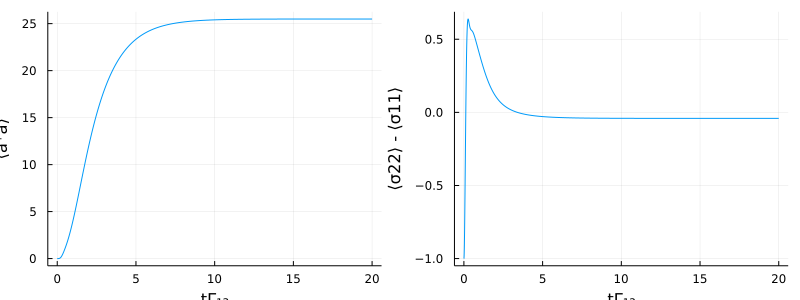

In [ ]:
n_t = real.(sol[average(a'*a)])
σ22m11_t = real.(2*sol[σ(2,2,1)] .+ sol[σ(3,3,1)] .-1 ) #σ11 + σ22 + σ33 = 𝟙

# Plot
p1 = plot(sol.t, n_t, xlabel="tΓ₁₂", ylabel="⟨a⁺a⟩", legend = false)
p2 = plot(sol.t, σ22m11_t, xlabel="tΓ₁₂", ylabel="⟨σ22⟩ - ⟨σ11⟩", legend = false)
plot(p1, p2, layout=(1,2), size=(800,300))